Лабораторная работа №3 (Вариант 2)

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sympy import symbols, sin, integrate
import scipy
import seaborn as sns
from scipy.stats import cor

tests = 10**6

In [27]:
fxy = lambda x, y: 1/2 * np.sin(x + y)
fx = lambda x: np.sqrt(2) / 2 * np.sin(x + (math.pi / 4))
fy = lambda y:  np.sqrt(2) / 2 * np.sin(y + (math.pi / 4))
fy_x = lambda x, y: np.sin(x + y) / (np.sin(x) + np.cos(x))

Генератор случайных чисел

In [28]:
class MultiplicativeCongruentSensor:
    def __init__(self, seed=19941994, lower=0, upper=math.pi / 2) -> None:
        self.seed = seed
        self.k = (2**32) - 5
        self.m = 2**64
        self.float_round = 5
        self.lower = lower
        self.upper = upper

    def get_value(self):
        self.seed = (self.k * self.seed) % self.m
        range_val = self.upper - self.lower
        return round((self.seed / self.m) * range_val, self.float_round) 


def x_y_generator(size, seed=None):
    if seed is None:
        seed = 1000000

    gen = MultiplicativeCongruentSensor()
    gen_p = MultiplicativeCongruentSensor(seed=seed, upper=1)

    x_l, y_l = [], []
    for _ in range(size):
        while True:

            x_, y_ = gen.get_value(), gen.get_value()
            z_ = gen_p.get_value()
            if fxy(x_, y_) >= z_:
                x_l.append(x_)
                y_l.append(y_)
                break

    return x_l, y_l

x, y = x_y_generator(tests)

Гистограммы составляющих X, Y для (1/2)*sin(x+y), 0 < x,y < pi/2 (Одинаковые)

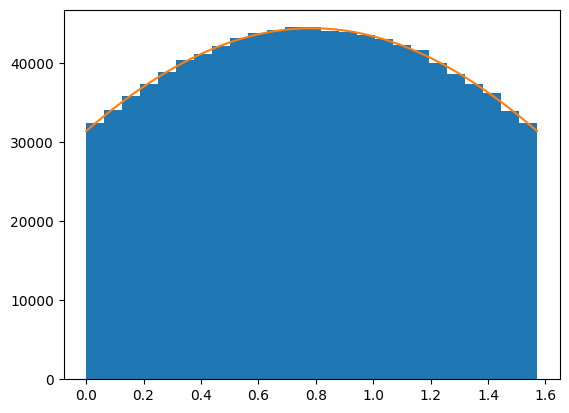

<Figure size 640x480 with 0 Axes>

In [5]:
x_points = np.linspace(0, np.pi / 2, num=100)
length = np.pi / 2 / 25
dist_points = fx(x_points) * tests * length

fix, ax = plt.subplots()
plt.hist(x, bins=25)
_ = sns.lineplot(x=x_points, y=dist_points, ax=ax)
plt.show()
plt.clf()

# Проверка составляющих двумерной НСВ на независимость
# f(x, y) = (1/2 sin(x + y), 0 < x,y < pi/2)

In [6]:
fx = lambda x: math.sqrt(2) / 2 * math.sin(x + (math.pi / 4))
fy = lambda y:  math.sqrt(2) / 2 * math.sin(y + (math.pi / 4))
fy_x = lambda x, y: math.sin(x + y) / (math.sin(x) + math.cos(x))

Теоретические значения для заданной плотности распределения

In [13]:
def integrand(x, y):
    return 1/2 * sin(x + y)

x_lower = 0
x_upper = math.pi/2
y_lower = 0
y_upper = math.pi/2

th_mean, _ = scipy.integrate.dblquad(lambda x, y: 
                                x * integrand(x, y), y_lower, y_upper, x_lower, x_upper)

th_variance, _ = scipy.integrate.dblquad(lambda x, y: (x - th_mean)**2 * integrand(x, y), y_lower, y_upper, x_lower, x_upper)
k_xy, _ = scipy.integrate.dblquad(lambda x, y: (x - th_mean) * (y - th_mean) * integrand(x, y), y_lower, y_upper, x_lower, x_upper)
stand_dev = math.sqrt(th_variance)
r_xy = k_xy / stand_dev**2

Практические значения

In [14]:
from scipy.stats import norm, chi2

def get_delta(offset, tests, porbability):
    t = norm.ppf(probability / 2 + 0.5)
    return t * offset / np.sqrt(tests)

# def get_offset_delta(test_offset, tests):
#     alphas = ((1 - probability) / 2, (1 + probability) / 2)
#     chis = (chi2.isf(alphas, tests - 1))
#     temp = np.sqrt(tests - 1) * test_offset
    
#     return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1]))

def get_offset_delta(offset, tests, probability):
    t = norm.ppf(probability / 2 + 0.5)
    return math.sqrt(2 / (tests - 1)) * offset * t

In [16]:
temp_res = []

for i in range(len(x)):
    temp_res.append(
        fy_x(x[i], y[i]))
    
for i in range(len(temp_res)):
    temp_res[i] += fx(x[i])

mo = sum(temp_res) / len(temp_res)

In [10]:
pract_mean_x = sum(x) / len(x)
pract_mean_y = sum(y) / len(y)

pract_disp_x = []
pract_disp_y = []

for i in range(len(x)):
    pract_disp_x.append(
        (x[i] - pract_mean_x)**2)
    pract_disp_y.append(
        (y[i] - pract_mean_y)**2)

pract_disp_x = sum(pract_disp_x) / (len(x) - 1)
pract_disp_y = sum(pract_disp_y) / (len(y) - 1)


stand_dev_x = math.sqrt(pract_disp_x)
stand_dev_y = math.sqrt(pract_disp_y)

probability = float(input("Введите вероятность накрытия доверительного интервалом полученной точечной оценки: "))

m_delta_x = get_delta(stand_dev_x, len(x), probability)
m_conf_int_x = th_mean - m_delta_x, th_mean + m_delta_x
m_delta_y = get_delta(stand_dev_y, len(y), probability)
m_conf_int_y = th_mean - m_delta_y, th_mean + m_delta_y

m_ofs_delta_x = get_offset_delta(pract_disp_x, len(x), probability) 
ofs_conf_int_x = th_variance - m_ofs_delta_x, th_variance + m_ofs_delta_x
m_ofs_delta_y = get_offset_delta(pract_disp_x, len(y), probability) 
ofs_conf_int_y = th_variance - m_ofs_delta_y, th_variance + m_ofs_delta_y

In [44]:
print("Теоретическое матожидание X и Y:", th_mean)
print("Практическое матожидание X:", pract_mean_x)
print("Практическое матожидание Y:", pract_mean_y)
print("Доверительный интервал матожидания X:", m_conf_int_x)
print("Доверительный интервал матожидания Y:", m_conf_int_y)
print()

print("Теоретическая дисперсия X и Y:", th_variance)
print("Практическая дисперсия X:", pract_disp_x)
print("Практическая дисперсия Y:", pract_disp_y)
print("Доверительный интервал дисперсии X:", ofs_conf_int_x)
print("Доверительный интервал дисперсии Y:", ofs_conf_int_y)

Теоретическое матожидание X и Y: 0.7853981633974483
Практическое матожидание X: 0.7854124869900279
Практическое матожидание Y: 0.7851189030200102
Доверительный интервал матожидания X: (0.7845494728529673, 0.7862468539419293)
Доверительный интервал матожидания Y: (0.784549536619884, 0.7862467901750125)

Теоретическая дисперсия X и Y: 0.18764660186298152
Практическая дисперсия X: 0.18750054963789436
Практическая дисперсия Y: 0.18747237474461043
Доверительный интервал дисперсии X: (0.18712688614550194, 0.1881663175804611)
Доверительный интервал дисперсии Y: (0.18712688614550194, 0.1881663175804611)


In [62]:
x = np.random.normal(th_mean, th_variance, 100000)
y = np.random.normal(th_mean, th_variance, 100000)
print(x)
print(y)

[0.84521094 1.07956524 0.89513721 ... 0.65328595 0.72102104 0.79917083]
[0.93526834 0.85873081 1.10722442 ... 0.83808106 0.91153949 0.56176803]


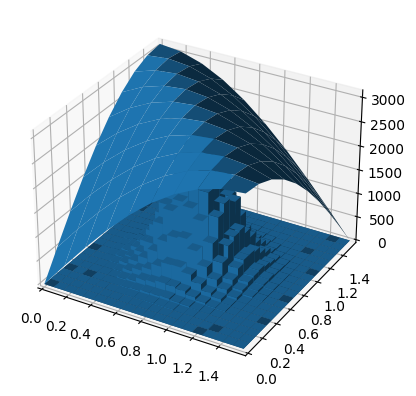

<Figure size 640x480 with 0 Axes>

In [65]:
x = np.random.normal(th_mean, th_variance, 100000)
y = np.random.normal(th_mean, th_variance, 100000)
bins = 20


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(
    x, 
    y, 
    bins=bins, 
    range=[[0, np.pi / 2], [0, np.pi / 2]]
)

length = np.pi / 2 / bins

xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = np.ones_like(zpos) * length
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.xlim([0, np.pi / 2])
plt.ylim([0, np.pi / 2])

def f(x, y):
    return 1/2 * np.sin(x + y) * np.square(length) * 10 ** 6

x = np.linspace(0, np.pi/2, 10)
y = np.linspace(0, np.pi/2, 10)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure()
ax.plot_surface(X, Y, Z)

plt.show()

# Задание 2

In [68]:
X = [1, 2, 3, 4, 5]
Y = [25, 173, 14, 27, 19]
P = [
    [0, 0, 0.05, 0.05, 0.1],
    [0.025, 0.025, 0.025, 0.025, 0.04],
    [0.05, 0.025, 0, 0, 0.1],
    [0.11, 0.07, 0.03, 0.05, 0.055],
    [0.070, 0.05, 0.05, 0, 0]
]

In [72]:
import numpy as np
from scipy.stats import chi2

# Задайте данные о двумерной случайной величине
# (замените значения xi и yi на свои данные)
xi = np.array(X)
yi = np.array(Y)

# Разделите значения X и Y на интервалы (корзины)
x_bins = np.unique(xi)
y_bins = np.unique(yi)

# Рассчитайте наблюдаемые частоты (Oij)
observed_freq, _, _ = np.histogram2d(xi, yi, bins=[x_bins, y_bins])

# Рассчитайте ожидаемые частоты (Eij)
expected_freq = np.outer(np.histogram(xi, bins=x_bins)[0], np.histogram(yi, bins=y_bins)[0])
expected_freq = expected_freq / np.sum(expected_freq)

# Рассчитайте статистику критерия Пирсона
chi2_statistic = np.sum((observed_freq - expected_freq) ** 2 / expected_freq)

# Рассчитайте степени свободы
df = (len(x_bins) - 1) * (len(y_bins) - 1)

# Рассчитайте критическое значение для заданного уровня значимости
alpha = 0.05
critical_value = chi2.ppf(1 - alpha, df)

# Выведите результаты проверки
print("Хи-квадрат статистика:", chi2_statistic)
print("Степени свободы:", df)
print("Критическое значение:", critical_value)

# Сравните статистику критерия Пирсона с критическим значением
if chi2_statistic > critical_value:
    print("Нулевая гипотеза отвергается. Переменные зависимы.")
else:
    print("Нет оснований отвергать нулевую гипотезу. Переменные независимы.")

Хи-квадрат статистика: 72.24999999999999
Степени свободы: 16
Критическое значение: 26.29622760486423
Нулевая гипотеза отвергается. Переменные зависимы.
